In [1]:
import numpy as np 
import os
import cv2

import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as keras
from keras.metrics import accuracy
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
%tensorflow_version 2.x

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [4]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(1,))
  predictions = tf.keras.layers.Dense(1)(inputs)
  model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.2))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13312685872793156
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10759226877206028671
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
def dice_coef(y_true, y_pred, smooth=1e-6):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
  return 1-dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(K.abs(y_true_f * y_pred_f))
  union = K.sum(y_true_f)+K.sum(y_pred_f) - intersection
  iou = K.mean((intersection + smooth) / (union + smooth))
  return iou


def res_block(x, nb_filters, strides):
    res_path = BatchNormalization()(x)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', strides=strides[0])(res_path)
    res_path = BatchNormalization()(res_path)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', strides=strides[1])(res_path)

    shortcut = Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[0])(x)
    shortcut = BatchNormalization()(shortcut)

    res_path = add([shortcut, res_path])
    return res_path


def encoder(x):
    to_decoder = []

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    main_path = BatchNormalization()(main_path)
    main_path = Activation(activation='relu')(main_path)

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(main_path)

    shortcut = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1))(x)
    shortcut = BatchNormalization()(shortcut)

    main_path = add([shortcut, main_path])
    # first branching to decoder
    to_decoder.append(main_path)

    main_path = res_block(main_path, [128, 128], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    main_path = res_block(main_path, [256, 256], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    return to_decoder


def decoder(x, from_encoder):
    main_path = UpSampling2D(size=(2, 2))(x)
    main_path = concatenate([main_path, from_encoder[2]], axis=3)
    main_path = res_block(main_path, [256, 256], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[1]], axis=3)
    main_path = res_block(main_path, [128, 128], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[0]], axis=3)
    main_path = res_block(main_path, [64, 64], [(1, 1), (1, 1)])

    return main_path


def res_unet1(input_shape = (256,256,3)):
    inputs = Input(shape=input_shape)

    to_decoder = encoder(inputs)

    path = res_block(to_decoder[2], [512, 512], [(2, 2), (1, 1)])

    path = decoder(path, from_encoder=to_decoder)

    path = Conv2D(filters=3, kernel_size=(1, 1), activation='sigmoid')(path)
    
    model = Model(inputs=inputs, outputs=path)
    model.compile(optimizer = Adam(learning_rate = 0.002), loss = 'binary_crossentropy', metrics = [dice_coef, iou_coef])
    
    return model

In [9]:
def listOfFiles(directory):

    x = []

    for root, dirs, files in os.walk(directory):

        for name in files:

            filename = os.path.join(root, name)

            y = filename.split('\\')

            x.append(y[0])
            
    x.sort()

    return x

In [10]:
print('*'*30)
print('Loading and preprocessing train data...')
print('*'*30)

path_train = '/content/drive/MyDrive/NIDA/Image_analytics/Project/datasets/Massachusetts_Roads_Dataset/tiff/train'
path_train_mask = '/content/drive/MyDrive/NIDA/Image_analytics/Project/datasets/Massachusetts_Roads_Dataset/tiff/train_labels'

img_train_path = listOfFiles(path_train)
img_train_mask_path = listOfFiles(path_train_mask)
img_train = []
mask_train = []

for i in range(1000):
  train_im = cv2.resize(cv2.cvtColor(cv2.imread(img_train_path[i]),cv2.COLOR_BGR2RGB), (256, 256))
  mask_im = cv2.resize(cv2.cvtColor(cv2.imread(img_train_mask_path[i]),cv2.COLOR_BGR2RGB), (256, 256))
  img_train.append(train_im)
  mask_train.append(mask_im)

img_train = np.array(img_train)
img_train = img_train.astype('float32')
img_train /= 255

mask_train = np.array(mask_train)
mask_train = mask_train.astype('float32')
mask_train /= 255
mask_train[mask_train > 0.5] = 1
mask_train[mask_train <= 0.5] = 0

print('*'*30)
print('Complete preprocessing train data...')
print('*'*30)

******************************
Loading and preprocessing train data...
******************************
******************************
Complete preprocessing train data...
******************************


In [11]:
print('*'*30)
print('Creating and compiling model...')
print('*'*30)
model = res_unet1()

******************************
Creating and compiling model...
******************************


In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [13]:
def plot_training_history(history):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_dic, ax_iou) = plt.subplots(1, 3, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_dic.plot(history.epoch, history.history["dice_coef"], label="Train dice")
    ax_dic.plot(history.epoch, history.history["val_dice_coef"], label="Validation dice")
    ax_dic.legend()
    ax_iou.plot(history.epoch, history.history["iou_coef"], label="Train iou")
    ax_iou.plot(history.epoch, history.history["val_iou_coef"], label="Validation iou")
    ax_iou.legend()

In [14]:
print('*'*30)
print('Fitting model...')
print('*'*30)

epochs = 200
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(f'resUnetwithMass_{epochs}epochs.h5', monitor='loss', save_best_only=True)

history =  model.fit(img_train, mask_train, batch_size=15, epochs=epochs, verbose=1, shuffle=True,
          validation_split=0.3,
          callbacks=[model_checkpoint, early_stopping])

******************************
Fitting model...
******************************
Epoch 1/200
47/47 [==============================] - 84s 1s/step - loss: 0.1997 - dice_coef: 0.1333 - iou_coef: 0.0718 - val_loss: 9.2012 - val_dice_coef: 4.5288e-05 - val_iou_coef: 2.8826e-05
Epoch 2/200
47/47 [==============================] - 53s 1s/step - loss: 0.1402 - dice_coef: 0.1828 - iou_coef: 0.1007 - val_loss: 1.6183 - val_dice_coef: 0.0026 - val_iou_coef: 0.0013
Epoch 3/200
47/47 [==============================] - 54s 1s/step - loss: 0.1321 - dice_coef: 0.2086 - iou_coef: 0.1167 - val_loss: 0.2273 - val_dice_coef: 0.0888 - val_iou_coef: 0.0465
Epoch 4/200
47/47 [==============================] - 56s 1s/step - loss: 0.1261 - dice_coef: 0.2437 - iou_coef: 0.1390 - val_loss: 0.2222 - val_dice_coef: 0.0963 - val_iou_coef: 0.0507
Epoch 5/200
47/47 [==============================] - 55s 1s/step - loss: 0.1209 - dice_coef: 0.2764 - iou_coef: 0.1607 - val_loss: 0.2216 - val_dice_coef: 0.1060 - val_iou_c

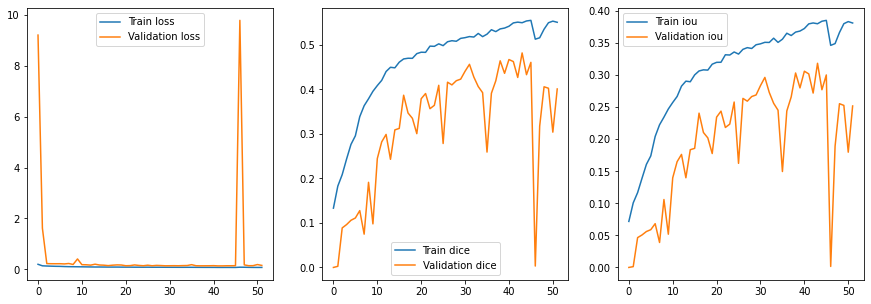

In [15]:
plot_training_history(history)

In [ ]:
print('*'*30)
print('Loading saved weights...')
print('*'*30)
model.load_weights('/content/drive/MyDrive/NIDA/Image_analytics/Project/UnetwithMass_100epochs.h5')

In [17]:
path_test = '/content/drive/MyDrive/NIDA/Image_analytics/Project/datasets/Massachusetts_Roads_Dataset/tiff/test'
path_mask_test = '/content/drive/MyDrive/NIDA/Image_analytics/Project/datasets/Massachusetts_Roads_Dataset/tiff/test_labels'

img_test_path = listOfFiles(path_test)
img_test_mask_path = listOfFiles(path_mask_test)


img_test = []
img_test_mask = []

for i in range(len(img_test_path)):
  test_im = cv2.resize(cv2.cvtColor(cv2.imread(img_test_path[i]),cv2.COLOR_BGR2RGB), (256, 256))
  mask_test_im = cv2.resize(cv2.cvtColor(cv2.imread(img_test_mask_path[i]),cv2.COLOR_BGR2RGB), (256, 256))
  img_test.append(test_im)
  img_test_mask.append(mask_test_im)


img_test = np.array(img_test)
img_test = img_test.astype('float32')
img_test /= 255

img_test_mask = np.array(img_test_mask)
img_test_mask = img_test_mask.astype('float32')
img_test_mask /= 255
img_test_mask[img_test_mask > 0.5] = 1
img_test_mask[img_test_mask <= 0.5] = 0


print('*'*30)
print('Evalute model on test data...')
print('*'*30)

eval = model.evaluate(img_test, img_test_mask)

******************************
Evalute model on test data...
******************************
2/2 [==============================] - 16s 4s/step - loss: 0.0876 - dice_coef: 0.4799 - iou_coef: 0.3160


In [18]:
path_pred = '/content/drive/MyDrive/NIDA/Image_analytics/Project/datasets/Massachusetts_Roads_Dataset/tiff/val'
img_pred_path = listOfFiles(path_pred)
img_pred = []

for i in range(len(img_pred_path)):
  pred_im = cv2.resize(cv2.cvtColor(cv2.imread(img_pred_path[i]),cv2.COLOR_BGR2RGB), (256, 256))
  img_pred.append(pred_im)

img_pred = np.array(img_pred)
img_pred = img_pred.astype('float32')
img_pred /= 255

print('*'*30)
print('Predicting masks on test data...')
print('*'*30)
mask_pred = model.predict(img_pred, verbose=1)

******************************
Predicting masks on test data...
******************************
1/1 [==============================] - 5s 5s/step


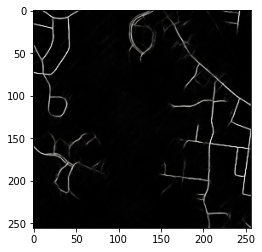

In [19]:
plt.imshow(mask_pred[10])

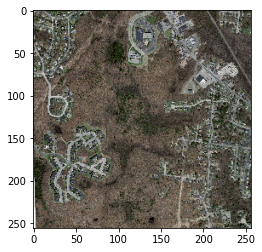

In [20]:
plt.imshow(img_pred[10])